# Zipf's Law

```yaml
course:   DS 5001 
module:   05 5 Lab
topic:    Zipfs Law and Open/Closed Terms
author:   R.C. Alvarado
date:     13 February 2024
```

# Set Up

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt

In [2]:
sns.set()

## Config

Change this to match the location of your data files.

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'

In [4]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [5]:
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [6]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index(BOOKS)
TOKEN = pd.read_csv(f'{output_dir}/{data_prefix}-TOKEN.csv').set_index(OHCO).dropna()
VOCAB = pd.read_csv(f'{output_dir}/{data_prefix}-VOCAB.csv').set_index('term_str').dropna()
POS_GROUP = pd.read_csv(f'{output_dir}/{data_prefix}-POS_GROUP.csv').set_index('pos_group')

# Zipf's Law

Recall the formula Zipf's law $f \propto \frac{1}{r} $, and $k =  fr$. 

We explore our data to see if it matches the formula.

## Add Term Rank to VOCAB

First, we compute the rank of each word, which is just its numeric index when inversely sorted by frequency.

In [7]:
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank' 
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_str')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

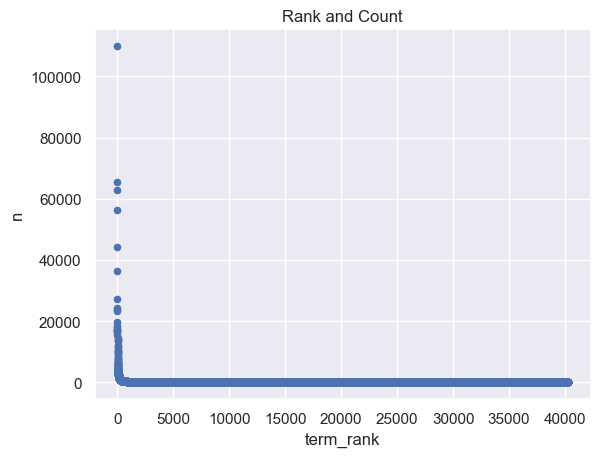

In [8]:
VOCAB.plot.scatter('term_rank', 'n', title="Rank and Count");

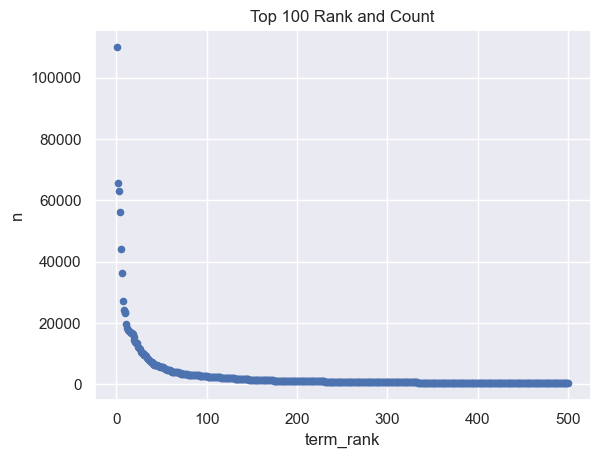

In [9]:
VOCAB.head(500).plot.scatter('term_rank', 'n', title="Top 100 Rank and Count");

## Guess Minimum Rank for Stop Words

In [10]:
min_rank = 200
SW = VOCAB[VOCAB.term_rank <= min_rank].index.tolist()

In [33]:
for i, sw in enumerate(SW):
    print(sw, end='')
    print() if (i+1) % 15 == 0 else print(' ', end='')

the of and to a in i was that it his he as with her
not for but be you had at is she all by on have my so
this from him which were they me no one their would an very we or
been there now what are could them more when some if said who upon will
like such your any do than must man into then out up much time mr
only our little other its being though did how well old before good every after
about never own most over should these long might mrs am two us may has
first down again can here yet great know see say himself think last without too
nothing still made day many way miss ever while thought soon those seemed where sir
men come away thing captain sea go off shall even through came make herself pierre
three young same just however hand house indeed always round having almost ship once something
place among look oh world quite room under far side life head another cried take
give myself nor part heart lady dear let better mind whale till few found back
half things poor morning night 

## Log View

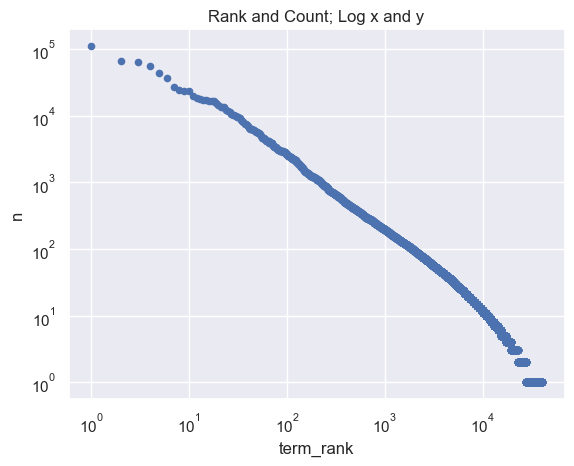

In [34]:
VOCAB.plot.scatter('term_rank', 'n', logx=True, logy=True, title="Rank and Count; Log x and y");

## Create Alternate Rank

Raw term rank has the problem of arbitrarily assigning rank numbers to terms that have the same count -- essentially terms with the same count are assigned a value based on their alphanumeric sort order. So we come up with a different rank that is a function of term count only.

In [13]:
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'index':'term_rank2', 'count':'nn'})\
    .set_index('n')

In [14]:
VOCAB['term_rank2'] = VOCAB.n.map(new_rank.term_rank2) + 1

# Compare Ranks

Note how the two ranks are related: the alternate rank groups more terms as frequency gets smaller.

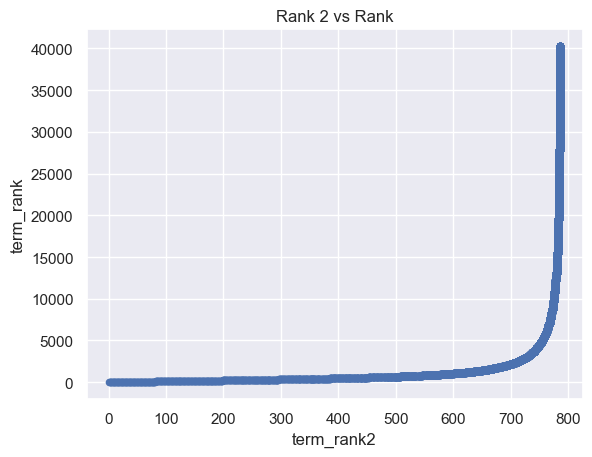

In [15]:
VOCAB.plot.scatter('term_rank2', 'term_rank', title="Rank 2 vs Rank");

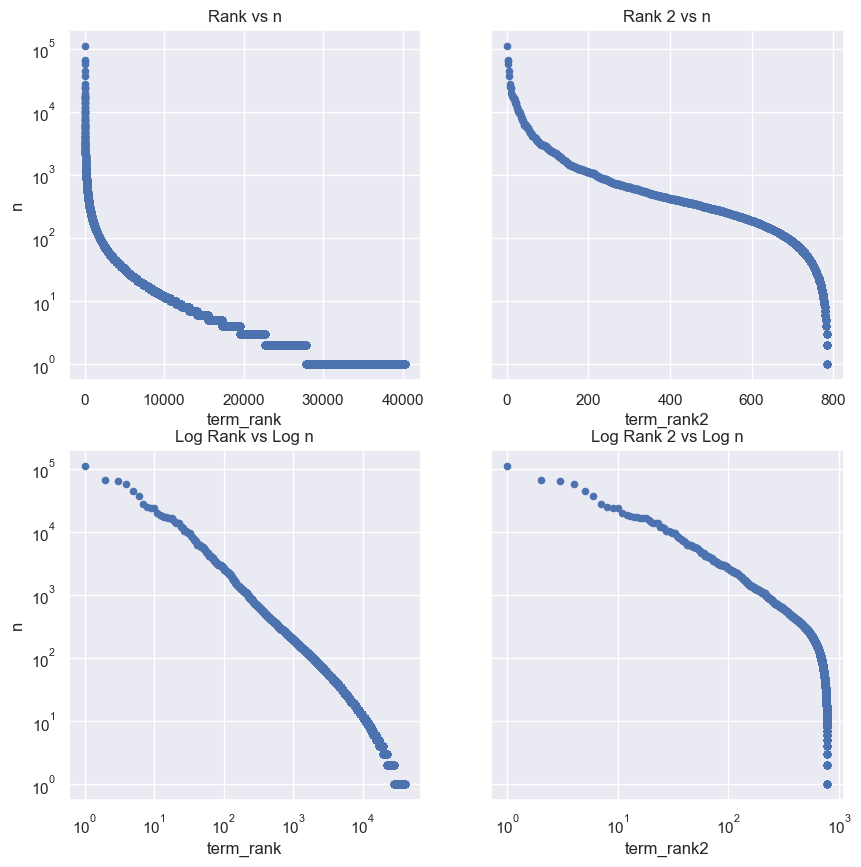

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharey=True)
VOCAB.plot.scatter('term_rank', 'n', title="Rank vs n", ax=axes[0,0])
VOCAB.plot.scatter('term_rank2', 'n', title="Rank 2 vs n", ax=axes[0,1]);
VOCAB.plot.scatter('term_rank', 'n', logx=True, logy=True, title="Log Rank vs Log n", ax=axes[1,0])
VOCAB.plot.scatter('term_rank2', 'n', logx=True, logy=True, title="Log Rank 2 vs Log n", ax=axes[1,1]);

## Compute Zipf's K

Now we see if K is linear as it's supposed to be.

In [17]:
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank
VOCAB['zipf_k2'] = VOCAB.n * VOCAB.term_rank2

## Rank and Zipf $k$

$k$ is supposed to be constant.

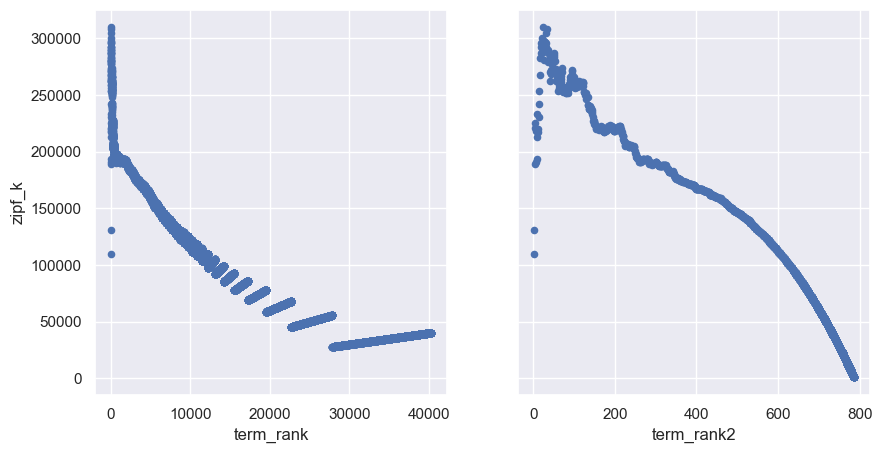

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
VOCAB.plot.scatter('term_rank', 'zipf_k', ax=axes[0])
VOCAB.plot.scatter('term_rank2', 'zipf_k2', ax=axes[1]);

## Demo Rank Index

We look at a sample drawn from rank increments to see global patterns in the corpus.

In [19]:
rank_index = [1, 2, 3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

In [20]:
DEMO = VOCAB.loc[VOCAB.term_rank.isin(rank_index)][['max_pos', 'p', 'term_rank', 'term_rank2', 'i', 'zipf_k', 'zipf_k2']]

In [21]:
DEMO.style.background_gradient(cmap='YlGnBu', high=.5)

,max_pos,p,term_rank,term_rank2,i,zipf_k,zipf_k2
term_str,,,,,,,
the,DT,0.053387,1,1,4.227375,109921,109921
of,IN,0.031824,2,2,4.973725,131050,131050
and,CC,0.030576,3,3,5.031473,188862,188862
it,PRP,0.011316,10,10,6.465503,232990,232990
you,PRP,0.006968,20,20,7.165021,286940,286940
so,RB,0.004730,30,30,7.724073,292140,292140
their,PRP$,0.003438,40,40,8.184357,283120,283120
are,VBP,0.002770,50,50,8.495725,285200,285200
will,MD,0.002192,60,60,8.833292,270840,270840


## Rank and Information

Rank and information appear to be closely related.

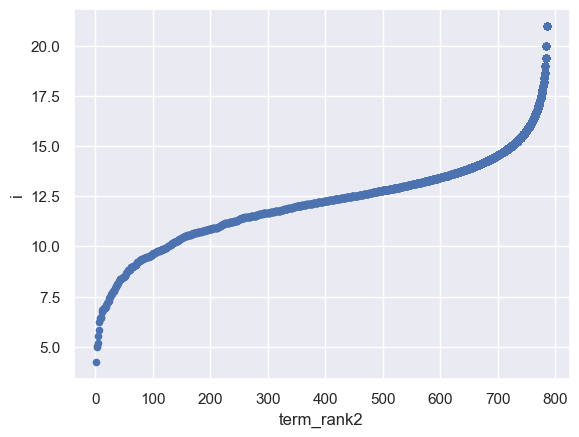

In [22]:
VOCAB.plot.scatter('term_rank2', 'i', logx=False, logy=False);

And, log $r$ tracks with $i$.

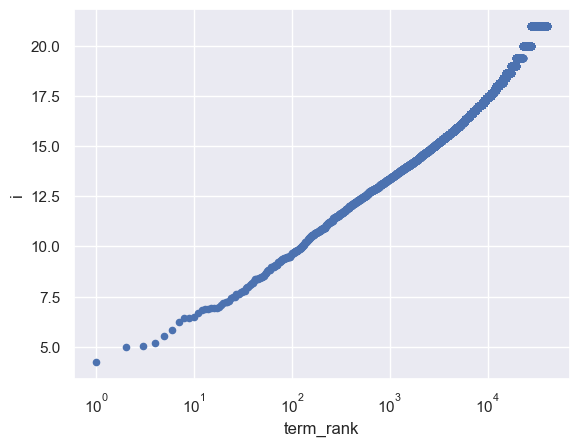

In [46]:
VOCAB.plot.scatter('term_rank', 'i', logx=True, logy=False);

In [43]:
VOCAB['log_r'] = np.log2(VOCAB.term_rank)

In [44]:
VOCAB[['log_r','i']].corr()

,log_r,i
log_r,1.000000,0.981704
i,0.981704,1.000000


Also, $i$ vs $r$ provides an example of logistic growth. 

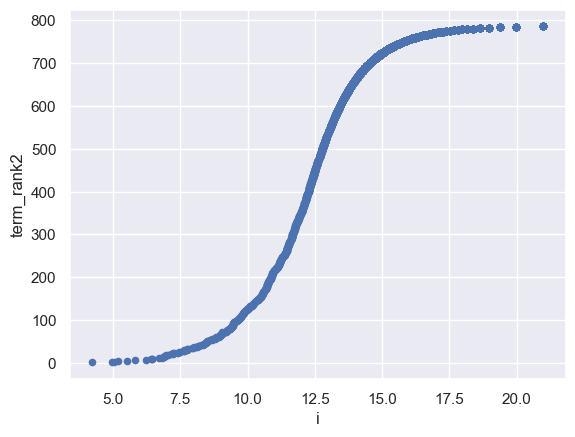

In [24]:
VOCAB.plot.scatter('i', 'term_rank2', logx=False, logy=False);

## Observations

* Zipf's law sheds light on a basic structure of language -- the division between words that do **grammatical work** and those that do **semantic work**.
* Zipf's constant is not borne out by the data. 
* Zipf's rank order does not group words with the same count; so, we've created an alternate rank based on word count groupings.
* Information $i$ may be used as a replacement for rank when exploring corpus level significance trends.

# Extra: Open vs Closed Words

Let's look at the concept of open and closed words.

We can do this by compare the number of types (terms) and tokens for each POS.

In [25]:
POS_GROUP['n_terms'] = VOCAB.max_pos.value_counts() 
POS_GROUP['n_tokens'] = VOCAB.groupby('max_pos').n.sum()

In [26]:
POS_GROUP['type_token_ratio'] = POS_GROUP.n_terms / POS_GROUP.n_tokens

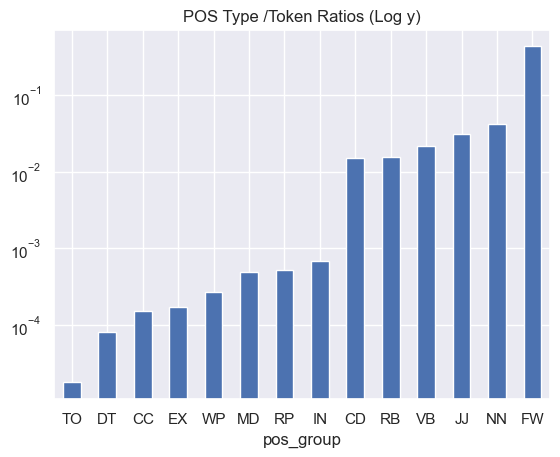

In [27]:
POS_GROUP.type_token_ratio.dropna().sort_values()\
    .plot.bar(logy=True, rot=0, title="POS Type /Token Ratios (Log y)");

We can see in both charts that two groups of words form.

| CLASS | TYPE/TOKEN | POS | THRESH |
|--|--|--|--|
| Open | High | Nouns, Adjectives, Verbs, Adverbs, Foreign Words* | $> 10^{-2}$ |
| Closed | Low | Function words | $< 10^{-3}$|

\*Foreigns words are typically nouns.

# Save

In [28]:
DEMO.to_csv(f"{output_dir}/{data_prefix}-DEMO.csv")
VOCAB.to_csv(f"{output_dir}/{data_prefix}-VOCAB_RANKED.csv")